<a href="https://colab.research.google.com/github/Mitmischer/solar-prediction/blob/max/solar%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()

In [6]:
#import condacolab
#condacolab.check()

In [7]:
#!wget https://files.pythonhosted.org/packages/ad/eb/82206deaf0cc020822465840edf0f9ac6b714be85a9b140be851dceee094/gpforecaster-0.3.142-py3-none-any.whl
#!pip install gpforecaster-0.3.142-py3-none-any.whl

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
#!chmod +x mini.sh
#!bash ./mini.sh -b -f -p /usr/local
#!conda install -q -y jupyter
#!conda install -q -y google-colab -c conda-forge
#!python -m ipykernel install --name "py38" --user

In [10]:
#!pip install gpforecaster

In [11]:
#!pip install git+https://github.com/luisroque/hierarchical_gp_forecaster

In [12]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.2 MB/s eta 0:00:00


In [13]:
!pip install git+https://github.com/RJT1990/pyflux
!pip install armagarch
!pip install statsmodels
!pip install statsforecast s3fs datasetsforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git@main

  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-25iaf6no
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-25iaf6no
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.4 MB/s eta 0:00:00
  Created wheel for pyflux: filename=pyflux-0.4.17-cp310-cp310-linux_x86_64.whl size=6694414 sha256=723399e68d1796094f5690def11b1bd21eb144e82fd1d02d71b6d1ee1564a279
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhf0suzg/wheels/64/db/82/5636b72b8936dc8ec217a1007a19490f604f8759766e7cbe46
Successfully built pyflux
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
import pandas as pd
import numpy as np
import armagarch as ag

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from datetime import datetime, timezone

# spectral analysis
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2

In [15]:
# with pandas 2.0, one could use date_format='%Y-%m-%d %H:%M:%S%z', but that's not yet available on Arch Linux
solar_ts=pd.read_csv("/content/drive/MyDrive/energy_charts.csv", sep=",", header=0)#date_format='%Y-%m-%d %H:%M:%S%z')#parse_dates={"date": ["Datum"]})

In [16]:
print(solar_ts['Datum'])

0         2015-01-01T00:00+01:00
1         2015-01-01T00:15+01:00
2         2015-01-01T00:30+01:00
3         2015-01-01T00:45+01:00
4         2015-01-01T01:00+01:00
                   ...          
327589    2024-05-05T10:15+02:00
327590    2024-05-05T10:30+02:00
327591    2024-05-05T10:45+02:00
327592    2024-05-05T11:00+02:00
327593    2024-05-05T11:15+02:00
Name: Datum, Length: 327594, dtype: object


<Axes: xlabel='Datum'>

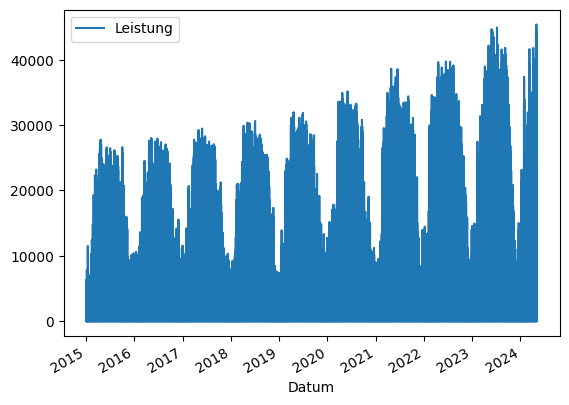

In [17]:
solar_ts['Datum']=pd.to_datetime(solar_ts['Datum'], format='%Y-%m-%dT%H:%M%z', utc=True)
solar_ts=solar_ts.set_index(keys="Datum",drop=True)
solar_ts.plot()

In [18]:
adfresult = adfuller(solar_ts[2:30000])
print(adfresult[0])
print(adfresult[1])

-22.445950944044935
0.0


<Axes: xlabel='Datum'>

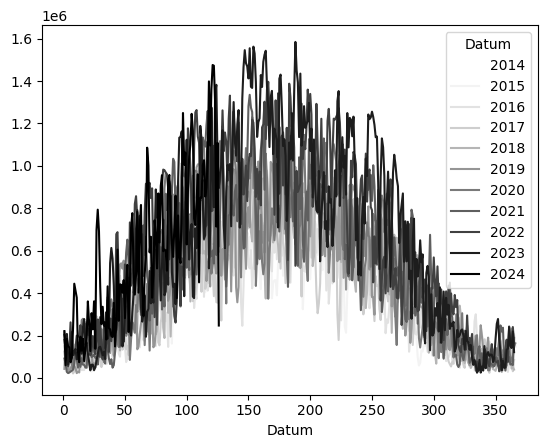

In [19]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(solar_ts, index=solar_ts.index.dayofyear, columns=solar_ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

<Axes: xlabel='Datum'>

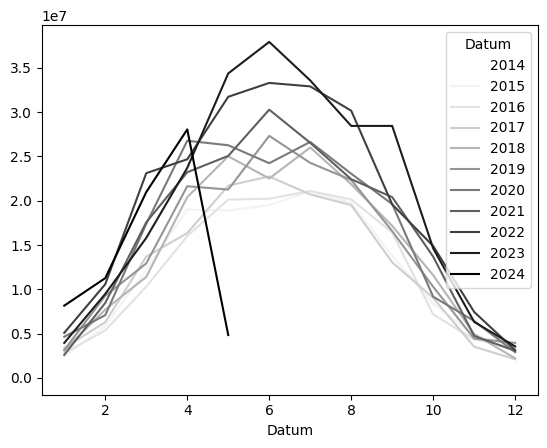

In [20]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(solar_ts, index=solar_ts.index.month, columns=solar_ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

In [21]:
# An example of a gap in the data
# TODO: Also, there is duplicate data here that pandas duplicated-function will not find...?
solar_ts.index[5660:5680]

DatetimeIndex(['2015-02-28 22:00:00+00:00', '2015-02-28 22:15:00+00:00',
               '2015-02-28 22:30:00+00:00', '2015-02-28 22:45:00+00:00',
               '2015-03-01 00:00:00+00:00', '2015-03-01 00:15:00+00:00',
               '2015-03-01 00:30:00+00:00', '2015-03-01 00:45:00+00:00',
               '2015-03-01 00:00:00+00:00', '2015-03-01 00:15:00+00:00',
               '2015-03-01 00:30:00+00:00', '2015-03-01 00:45:00+00:00',
               '2015-03-01 01:00:00+00:00', '2015-03-01 01:15:00+00:00',
               '2015-03-01 01:30:00+00:00', '2015-03-01 01:45:00+00:00',
               '2015-03-01 02:00:00+00:00', '2015-03-01 02:15:00+00:00',
               '2015-03-01 02:30:00+00:00', '2015-03-01 02:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datum', freq=None)

In [22]:
pd.Series(solar_ts.index.duplicated()).value_counts()

False    327522
True         72
Name: count, dtype: int64

In [23]:
(pd.Series(solar_ts.index[5660:5680]).diff())

0                  NaT
1      0 days 00:15:00
2      0 days 00:15:00
3      0 days 00:15:00
4      0 days 01:15:00
5      0 days 00:15:00
6      0 days 00:15:00
7      0 days 00:15:00
8    -1 days +23:15:00
9      0 days 00:15:00
10     0 days 00:15:00
11     0 days 00:15:00
12     0 days 00:15:00
13     0 days 00:15:00
14     0 days 00:15:00
15     0 days 00:15:00
16     0 days 00:15:00
17     0 days 00:15:00
18     0 days 00:15:00
19     0 days 00:15:00
Name: Datum, dtype: timedelta64[ns]

In [24]:
# Those values need imputation!
pd.date_range(solar_ts.index.min(), solar_ts.index.max(), freq='15Min').difference(solar_ts.index)

DatetimeIndex(['2015-02-28 23:00:00+00:00', '2015-02-28 23:15:00+00:00',
               '2015-02-28 23:30:00+00:00', '2015-02-28 23:45:00+00:00',
               '2015-09-25 02:00:00+00:00', '2015-09-25 02:15:00+00:00',
               '2015-09-25 02:30:00+00:00', '2015-09-25 02:45:00+00:00',
               '2016-02-27 02:00:00+00:00', '2016-02-27 02:15:00+00:00',
               '2016-02-27 02:30:00+00:00', '2016-02-27 02:45:00+00:00',
               '2016-09-30 02:00:00+00:00', '2016-09-30 02:15:00+00:00',
               '2016-09-30 02:30:00+00:00', '2016-09-30 02:45:00+00:00',
               '2017-02-26 02:00:00+00:00', '2017-02-26 02:15:00+00:00',
               '2017-02-26 02:30:00+00:00', '2017-02-26 02:45:00+00:00',
               '2017-09-29 02:00:00+00:00', '2017-09-29 02:15:00+00:00',
               '2017-09-29 02:30:00+00:00', '2017-09-29 02:45:00+00:00',
               '2018-02-25 02:00:00+00:00', '2018-02-25 02:15:00+00:00',
               '2018-02-25 02:30:00+00:00', '2018-0

In [25]:
# This add NaN as value for the missing indices, we can impute this later.
solar_ts = solar_ts.resample("15Min").first()
# As only a few values need imputation, so the choice of the imputation algorithm does not matter much.
solar_ts = solar_ts.interpolate(method="time")
# Only now can we infer a frequency.
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))

In [26]:
# There are no duplicated dates, good!
# (Although, a bit questionable, see above)
np.count_nonzero(solar_ts.index.duplicated())

0

In [27]:
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))

<Axes: xlabel='Datum'>

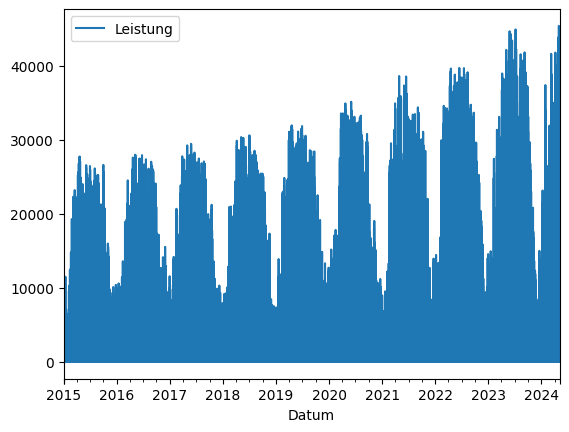

In [28]:
solar_ts.plot()

In [29]:
solar_ts_series = solar_ts.Leistung

<Axes: xlabel='Datum'>

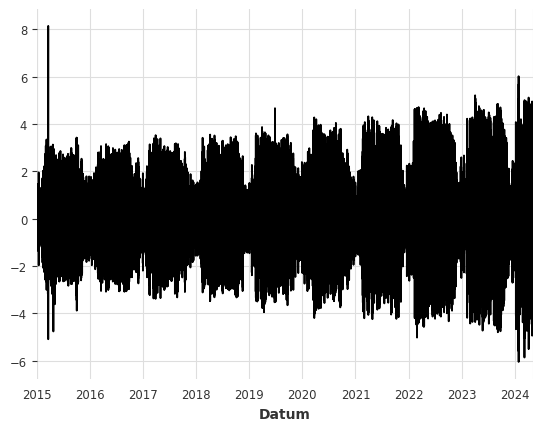

In [69]:
# Normalize
train_size = int(len(solar_ts_series) * 0.7)
ts_train = solar_ts_series[:train_size]
ts_test = solar_ts_series[train_size:]

# we cannot normalize over the test data as we don't have that yet!
avg, dev = ts_train.mean(), ts_train.std()
solar_ts_series = (solar_ts_series - avg)/dev
solar_ts_series.plot()

<Axes: xlabel='Datum'>

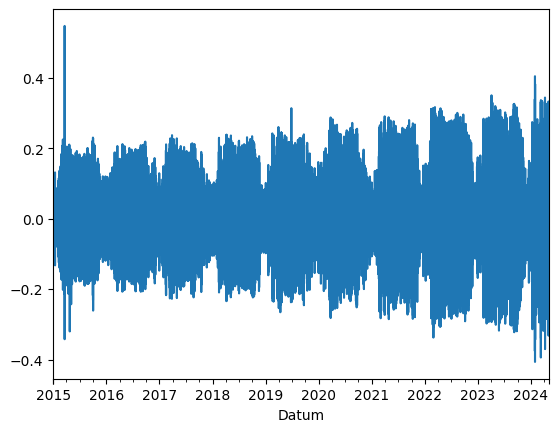

In [31]:
# Remove trend (TODO: compare with the approach in the Fourier series video, where they also detrend?)
solar_ts_series = solar_ts_series.diff().dropna()
solar_ts_series.plot()

In [32]:
# Consider taking another difference: solar_ts_series = solar_ts_series.diff().dropna()
# solar_ts_series.plot()

In [33]:
# remove increasing volatility - or (TODO: use a (G)ARCH here).
annual_volatility = solar_ts_series.groupby(solar_ts_series.index.year).std()
annual_vol_per_day = solar_ts_series.index.map(lambda d: annual_volatility.loc[d.year])
solar_ts_series_corrected_variance = solar_ts_series/annual_vol_per_day

In [34]:
annual_volatility

Datum
2014    0.000000
2015    0.059382
2016    0.058232
2017    0.060318
2018    0.068400
2019    0.070074
2020    0.076130
2021    0.078294
2022    0.092524
2023    0.094256
2024    0.096496
Name: Leistung, dtype: float64

In [35]:
annual_vol_per_day

Index([                 0.0,                  0.0,                  0.0,
       0.059382013550229464, 0.059382013550229464, 0.059382013550229464,
       0.059382013550229464, 0.059382013550229464, 0.059382013550229464,
       0.059382013550229464,
       ...
        0.09649560072446868,  0.09649560072446868,  0.09649560072446868,
        0.09649560072446868,  0.09649560072446868,  0.09649560072446868,
        0.09649560072446868,  0.09649560072446868,  0.09649560072446868,
        0.09649560072446868],
      dtype='float64', name='Datum', length=327593)

In [36]:
if False:
  solar_ts_series_corrected_variance.plot()

In [37]:
# ritvik takes monthly means here
# why not take dayofyear?
monthly_mean = solar_ts_series_corrected_variance.groupby(solar_ts_series_corrected_variance.index.month).mean()
monthly_mean_per_day = solar_ts_series_corrected_variance.index.map(lambda d: monthly_mean.loc[d.month])

In [38]:
solar_ts_series_corrected_variance= solar_ts_series_corrected_variance - monthly_mean_per_day

In [39]:
if False:
  solar_ts_series_corrected_variance.plot()

In [40]:
# we only take the first few samples as my RAM explodes otherwise
adfresult = adfuller(solar_ts_series_corrected_variance[3:30000])
print(adfresult[0])
print(adfresult[1])
adfresult = adfuller(solar_ts_series_corrected_variance[120000:150000])
print(adfresult[0])
print(adfresult[1])

-45.67468183971967
0.0
-43.566228511871664
0.0


In [41]:
solar_ts_series_corrected_variance=solar_ts_series_corrected_variance[~np.isnan(solar_ts_series_corrected_variance)]
solar_ts_series_corrected_variance

Datum
2015-01-01 00:00:00+00:00   -2.138057e-19
2015-01-01 00:15:00+00:00   -2.138057e-19
2015-01-01 00:30:00+00:00   -2.138057e-19
2015-01-01 00:45:00+00:00   -2.138057e-19
2015-01-01 01:00:00+00:00   -2.138057e-19
                                 ...     
2024-05-05 08:15:00+00:00    1.687818e+00
2024-05-05 08:30:00+00:00    1.609537e+00
2024-05-05 08:45:00+00:00    1.243852e+00
2024-05-05 09:00:00+00:00    1.024665e+00
2024-05-05 09:15:00+00:00    1.041066e+00
Freq: 15T, Length: 327590, dtype: float64

# some spectral analysis

(0.0, 10000.0)

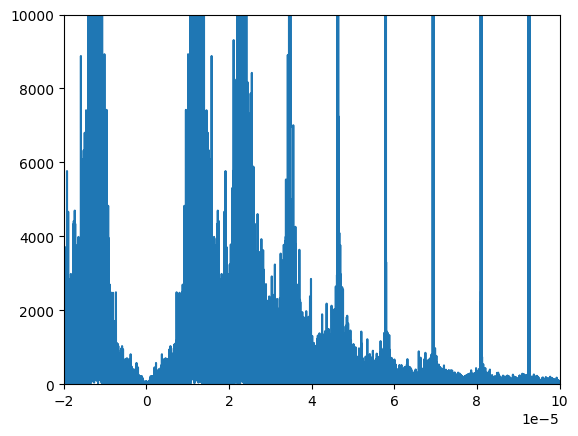

In [42]:
# ts has period 15 minutes
dt = 15*60
rate = 1/dt
periodogram = np.abs(fft(np.asarray(solar_ts_series_corrected_variance)))**2*dt/(len(solar_ts_series_corrected_variance))
frequencies = fftfreq(len(solar_ts_series_corrected_variance), d=1/rate)
frequencies
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 0.0001)
plt.ylim(0, 10000)

(0.0, 10000.0)

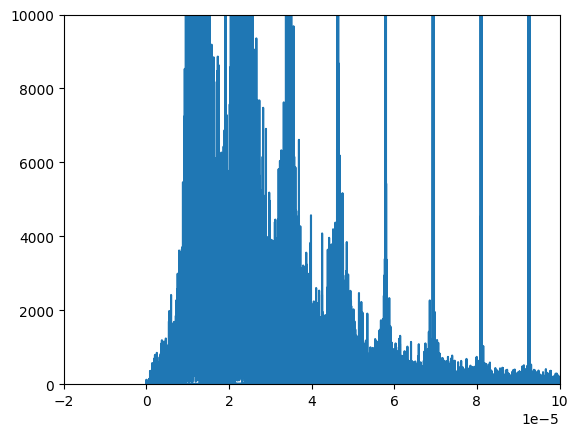

In [43]:
# looks (and should be!) similar to the "manual" calculation above.
# Note that in the manual calculation, we get a symmetric graph. That's to be expected (check out the videos).
frequencies, periodogram = periodogram_f(np.asarray(solar_ts_series_corrected_variance), fs=rate, window="hamming")
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 0.0001)
plt.ylim(0, 10000)

In [44]:
periodogram_as_series = pd.Series(fftshift(periodogram), index=fftshift(frequencies))
periodogram_as_series = periodogram_as_series[periodogram_as_series.index > 0]

In [45]:
# convert index from frequencies to periods and convert the periods to hours
# TODO: is the calculation to hours correct (note that  we already specified the sampling rate during the fft!)?
periodogram_as_series.index = (1/periodogram_as_series.index)/3600

(0.0, 27.77777777777778)

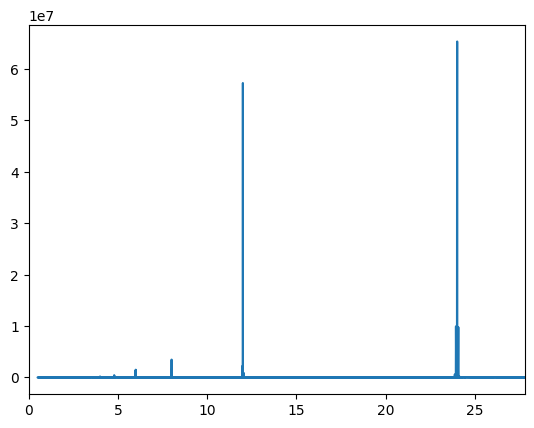

In [46]:
plt.plot(periodogram_as_series)
plt.xlim(0,100000/3600)

In [47]:
# TODO: use SARIMA, => detrend and remove saisonality
# Take a look the the residuals
# is the model good?
# Then, the residuals have no (p)ACF
# check QQ - WN has no heavy tails :)
# also consider: https://www.youtube.com/watch?v=4zV-ZyQHl7s

# TODO: decompose + fit SARIMA model
# before: continue with denoising :)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 100.0)

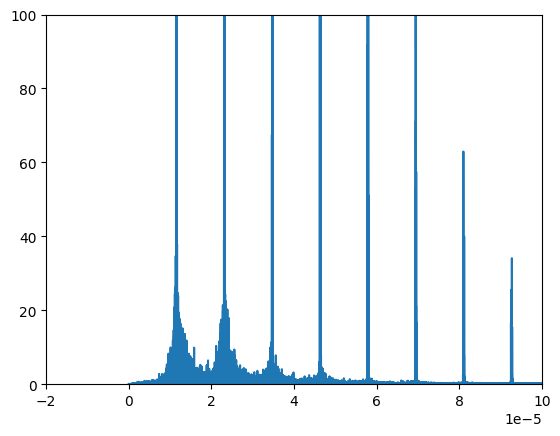

In [48]:
# yet another way to calculate the FFT, from the "denoising" video.
# However, apparently, the signal is now dampened. The frequencies themselves are correct, though
# Note how damped the signal appears visually already although the y-scale is really small!
n = len(solar_ts_series_corrected_variance)
fhat = np.fft.fft(solar_ts_series_corrected_variance, n)
PSD = fhat*np.conj(fhat)/n
freq = (1/(dt*n))*np.arange(n)
L= np.arange(1, np.floor(n/2), dtype="int")
plt.plot(freq[L], PSD[L])
plt.xlim(-0.00002, 0.0001)
plt.ylim(0, 100)

[]

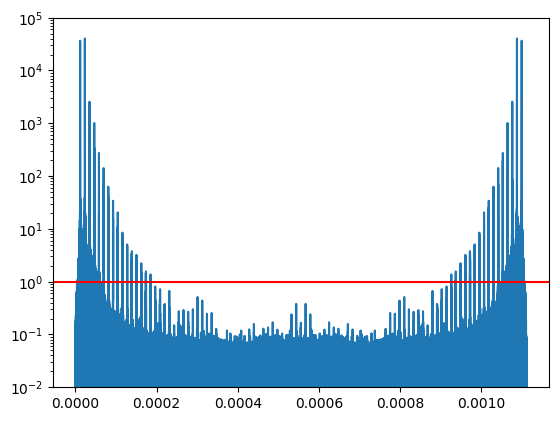

In [49]:
# Now decide on the frequencies to cut off.
plt.plot(freq, PSD)
plt.ylim(1e-2,1e5)
plt.axhline(y=1e0, color="r")
plt.semilogy()

In [50]:
# We'll only retain frequencies with powers above the red line in the graph above.
# I chose it such that almost all high-power frequencies are retained. We get some noisy frequencies in (at the tails) but the majority is filtered.
indices = PSD > 1e0
# Filter and reconstruct the signal on the retained frequencies (reverse fourier transform)
PSDclean = PSD*indices
fhat = indices*fhat
ffilt = np.fft.ifft(fhat)

[]

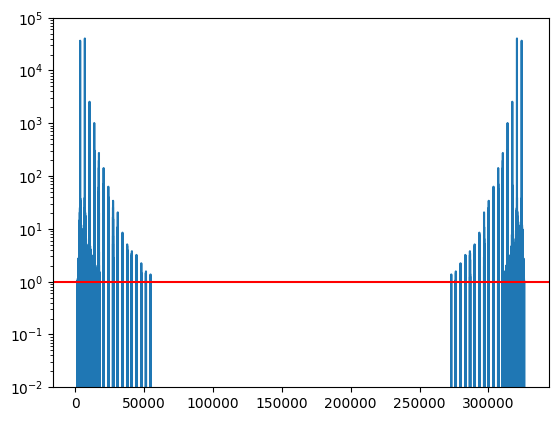

In [51]:
# small sanity check: our new spectrum looks like this: nice, huh?
plt.plot(PSDclean)
plt.ylim(1e-2,1e5)
plt.axhline(y=1e0, color="r")
plt.semilogy()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


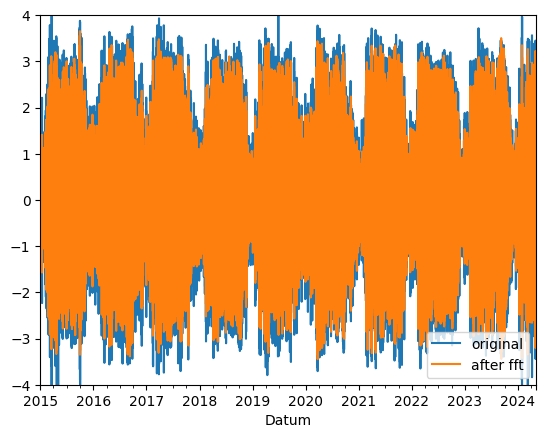

In [52]:
solar_ts_series_corrected_variance.plot()
plt.ylim(-4,4)
pd.Series(ffilt, solar_ts_series_corrected_variance.index).plot()
plt.ylim(-4,4)
plt.legend(["original", "after fft"])

# FT model

In [53]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.0 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193267 sha256=ec262d27ae3c4244de4034490737ab557c5b67d34b9dac49bedb4f8b2be9f985
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod


In [54]:
# Evtl. erwägen eins der GP-Repos zu porten? z.B. ABCDflow?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset, AirPassengersDataset, EnergyDataset

In [176]:
from darts import TimeSeries

train_size = int(len(solar_ts_series_corrected_variance) * 0.75)
ts_train = solar_ts_series_corrected_variance[:train_size]
ts_test = solar_ts_series_corrected_variance[train_size:]

darts_ts_train = TimeSeries.from_series(ts_train)
darts_ts_test = TimeSeries.from_series(ts_test)

In [187]:
plt.figure(figsize=(19,4))

<Figure size 1900x400 with 0 Axes>

<Figure size 1900x400 with 0 Axes>

In [192]:
def do_fourier(model, darts_ts_train, darts_ts_test):
  model.fit(darts_ts_train)
  pred_val = model.predict(len(darts_ts_test))
  plt.figure(figsize=(24,4))
  darts_ts_train.plot(label="train")
  darts_ts_test.plot(label="val")
  print("MAE:", mae(pred_val, darts_ts_test))
  return pred_val.plot(label="prediction")

MAE: 1.158385573384184


<Axes: xlabel='Datum'>

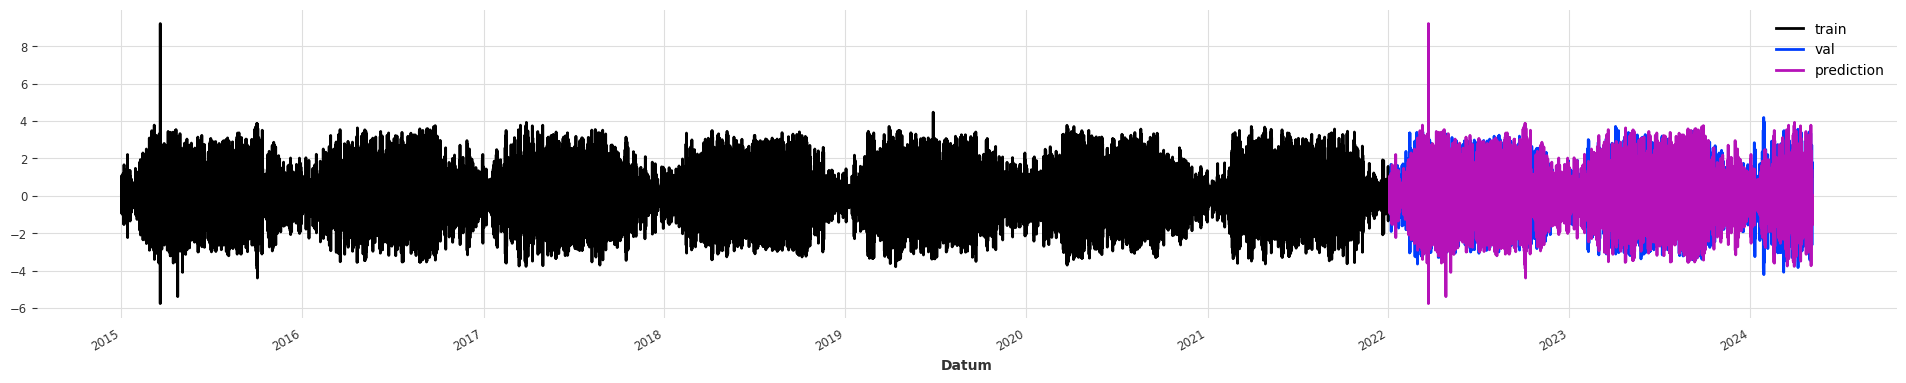

In [193]:
# evtl. Abfolge ganz interessant:
# schlecht: model = FFT(required_matches=set(), nr_freqs_to_keep=None)
# todo: mit dem Parameter nr_freqs_to_keep rumspielen, der ist sehr wichtig!!
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 1.1476181461151316


<Axes: xlabel='Datum'>

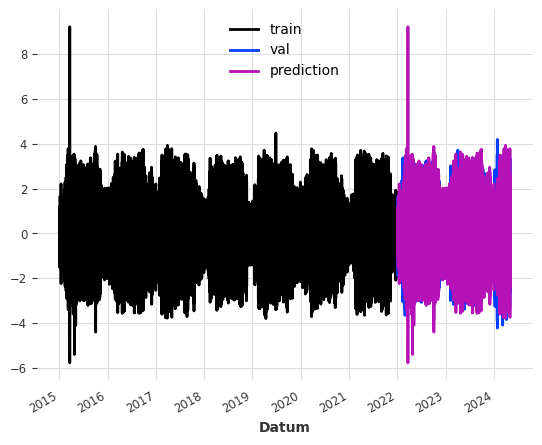

In [179]:
model = FFT(required_matches={"month"}, nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 1.158385573384184


<Axes: xlabel='Datum'>

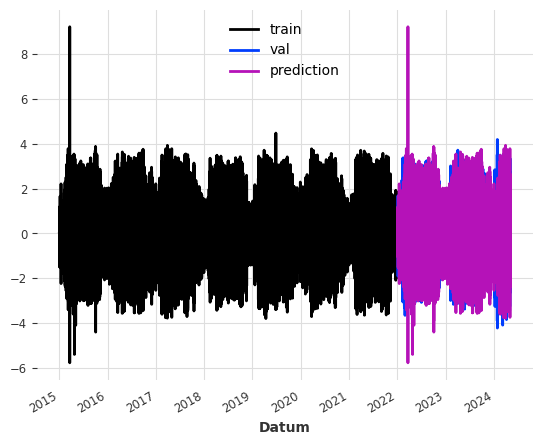

In [182]:
model = FFT(nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 1.1707582277807935


<Axes: xlabel='Datum'>

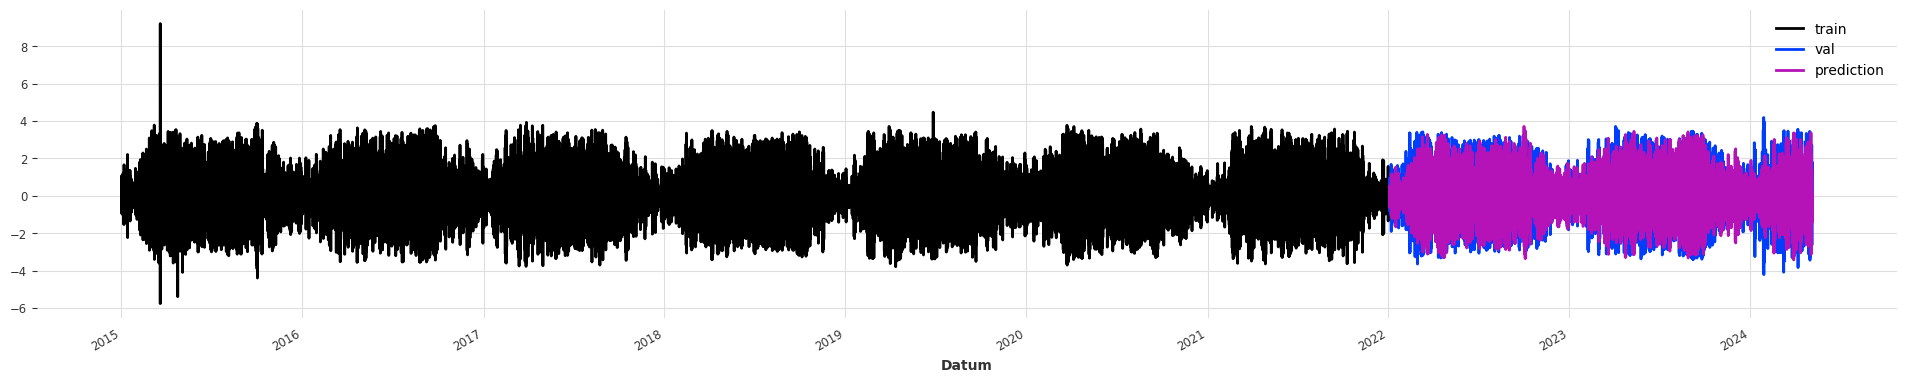

In [194]:
model = FFT(nr_freqs_to_keep=8000)
do_fourier(model, darts_ts_train, darts_ts_test)

In [196]:
model = FFT(nr_freqs_to_keep=8000)
model.gridsearch(
  parameters={
      "nr_freqs_to_keep": [100, 500, 1000, 5000, 10000]
  },
  series=darts_ts_train,
  val_series=darts_ts_test,
  verbose=True
)

#do_fourier(model, darts_ts_train, darts_ts_test)

100%|██████████| 5/5 [05:24<00:00, 64.97s/it]


(FFT(nr_freqs_to_keep=10000, required_matches=None, trend=None, trend_poly_degree=3),
 {'nr_freqs_to_keep': 10000},
 1.9959226874932734e+20)

MAE: 1.3198611752131668


<Axes: xlabel='Datum'>

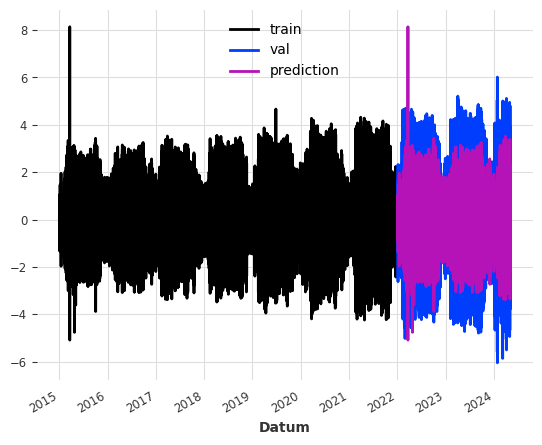

In [181]:
# now on the data with original (=increasing) volatility

ts_train_orig = solar_ts_series[:train_size]
ts_test_orig = solar_ts_series[train_size:]

darts_ts_train_orig = TimeSeries.from_series(ts_train_orig)
darts_ts_test_orig = TimeSeries.from_series(ts_test_orig)
ts_cont_pred = TimeSeries.from_series(pd.Series((3*list(ts_train_orig[-365*24*4:].values))[0:len(ts_test_orig.index)], index=ts_test_orig.index))


model = FFT(nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train_orig, darts_ts_test_orig)

MAE: 1.3265625070158367


<Axes: xlabel='Datum'>

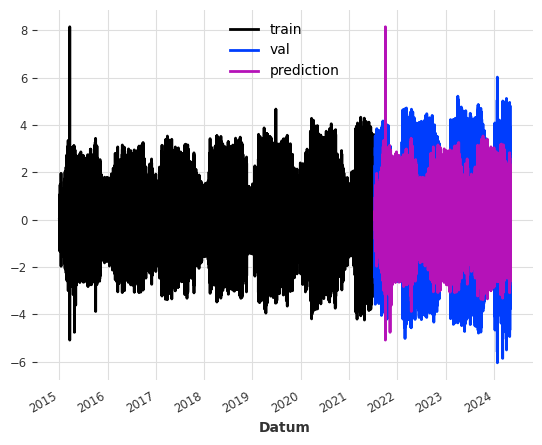

In [79]:
model = FFT(nr_freqs_to_keep=None, trend="poly")
do_fourier(model, darts_ts_train_orig, darts_ts_test_orig)

MAE: 0.34331444586993043


<Axes: xlabel='Datum'>

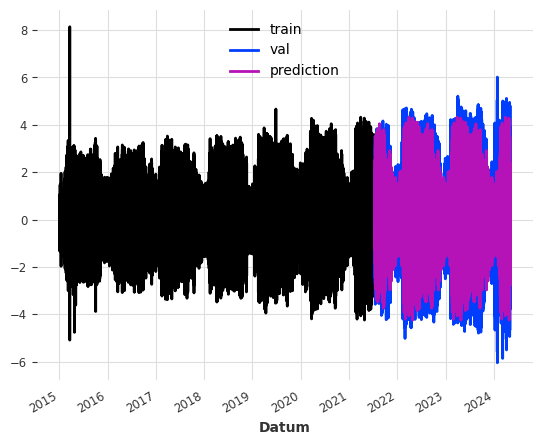

In [180]:
# Evtl. als spannende zulässige baselines:
# das Jahr vorher?
# der Tag vorher?

darts_ts_train_orig.plot(label="train")
darts_ts_test_orig.plot(label="val")
print("MAE:", mae(ts_cont_pred, darts_ts_test_orig))
ts_cont_pred.plot(label="prediction")

In [155]:
ts_cont_pred

Datum
2021-07-16 16:00:00+00:00   -1.235142
2021-07-16 16:15:00+00:00   -1.158788
2021-07-16 16:30:00+00:00   -1.078510
2021-07-16 16:45:00+00:00   -1.181266
2021-07-16 17:00:00+00:00   -1.133099
                               ...   
2024-05-05 08:15:00+00:00    1.014263
2024-05-05 08:30:00+00:00    0.713486
2024-05-05 08:45:00+00:00    0.268386
2024-05-05 09:00:00+00:00    0.628390
2024-05-05 09:15:00+00:00    0.004894
Freq: 15T, Length: 98278, dtype: float64

# GARCH1


In [ ]:
# solar_ts_series is demeaned but not corrected for increasing variance (which is why we deploy the GARCH model in the first place)

In [ ]:
import pyflux as pf

In [ ]:
solar_ts_series
solar_ts_series = pd.Series(solar_ts_series)
solar_ts_series

In [ ]:
model = pf.GARCH(solar_ts_series.reset_index(drop=True).values[0:3000],p=1,q=1)
x = model.fit()
x.summary()

In [ ]:
model.plot_fit(figsize=(19,4))

In [ ]:
np.abs(solar_ts_series).plot(figsize=(14,4))

In [ ]:
model.plot_predict(h=30)

In [ ]:
model.plot_predict_is(h=200)

In [ ]:
# Conclusion: Excellent fit (almost "too perfect"), but high uncertainty. Not fit for predictions, really..
# TODO: Evtl. noch ein Plot mit der echten prediction?
# Evtl. in Ordnung für nur eine weitere Stunde, also mit backtesting?
# Können wir das auch für einene größeren horizon?

# GARCH2

In [ ]:
import statsmodels.api as sm # Import statsmodels.api

meanMdl = ag.ARMA(order = {'AR':1,'MA':1})
volMdl = ag.garch(order = {'p':1,'q':1})
distMdl = ag.normalDist()

# create a model
# Dont want to wait!
model = ag.empModel(solar_ts_series[1:1000].to_frame(), meanMdl, volMdl, distMdl)
# Fit model
model.fit()

pred = model.predict(nsteps=4*24)
mean_pred, var_pred = pred


# Plot the actual data and the forecast for the last 100 observations
plt.figure(figsize=(10, 6))

# Plot the actual data for the last 100 observations
plt.plot(solar_ts_series[-100:], label='Actual Data')

# Plot the forecasted mean, starting from the last actual value
last_observation_index = solar_ts_series.index[-1]
forecast_index = pd.date_range(start=last_observation_index, periods=len(mean_pred) + 1, freq="15min")[1:]
plt.plot(forecast_index[-100:], mean_pred[-100:], label='Forecasted Mean', color='red')

# Fill between upper and lower bounds of the forecasted variance
plt.fill_between(forecast_index[-100:],
                 mean_pred[-100:] - np.sqrt(var_pred[-100:]),
                 mean_pred[-100:] + np.sqrt(var_pred[-100:]),
                 color='red', alpha=0.2, label='Forecasted Variance')

plt.title('ARMA-GARCH Forecast (Last 100 Observations)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


# AD1

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def AE_anomaly_detection(x_train, x_test, time_steps=TIME_STEPS):
    training_mean = x_train.mean()
    training_std = x_train.std()
    df_training_value = (x_train - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))

    x_train = create_sequences(df_training_value.values)
    print("Training input shape: ", x_train.shape)

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
       ],
    )
    # Get train MAE loss.
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)


##### test ...

    test_mean = x_test.mean()
    test_std = x_test.std()
    ####### prepare the test data
    df_test_value = (x_test - test_mean) / test_std
    #fig, ax = plt.subplots()
    #df_test_value.plot(legend=False, ax=ax)
    #plt.show()

    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values)
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    # das hier müssen wir später auf all unsere samples geben, um die
    #  Anomalien zu entdecken.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold
    print(anomalies)
    print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    return anomalies

  # evtl. hier stattdessen das LSTM reinhauen
  # Vorschlag hierfür:
  #model = Sequential()
#model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(rate=0.2))
#model.add(RepeatVector(X_train.shape[1]))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(rate=0.2))
#model.add(TimeDistributed(Dense(X_train.shape[2])))
#model.compile(optimizer='adam', loss='mae')
#model.summary()

In [ ]:
TIME_STEPS = 288

df_daily_jumpsup = solar_ts_series

##### plot anomalies
anomalies = AE_anomaly_detection(solar_ts_series.iloc[1:8000].to_frame(), solar_ts_series.iloc[8001:10000].to_frame(), time_steps=TIME_STEPS)

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
test_mean = df_daily_jumpsup.mean()
test_std = df_daily_jumpsup.std()
df_test_value = (df_daily_jumpsup - test_mean) / test_std

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [ ]:
solar_ts_series.iloc[1:3000]

In [ ]:
solar_ts_series.iloc[1:3000].to_frame()

#AD2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers
import random
import pandas as pd
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

In [ ]:
solar_ts_series.index

# NBEATS (Darts)

In [200]:

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate

In [206]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

<Axes: xlabel='Datum'>

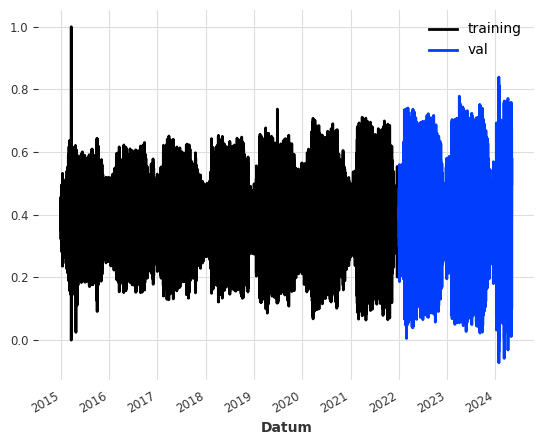

In [203]:
scaler = Scaler()

darts_ts_train_orig = TimeSeries.from_series(ts_train_orig)
darts_ts_test_orig = TimeSeries.from_series(ts_test_orig)

darts_ts_train_orig_scaled = scaler.fit_transform(darts_ts_train_orig)
darts_ts_test_orig_scaled = scaler.transform(darts_ts_test_orig)
darts_ts_full_orig_scaled = scaler.transform(TimeSeries.from_series(solar_ts_series))

darts_ts_train_orig_scaled.plot(label="training")
darts_ts_test_orig_scaled.plot(label="val")

In [208]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)





In [210]:
# 5000 just for now, do not overload the poor CPU!
model_nbeats.fit(darts_ts_train_orig_scaled[1:5000], val_series=darts_ts_test_orig_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.1 M  | train
-------------------------------------------------------------
8.1 M     Trainable params
2.7 K     Non-trainable params
8.1 M     Total params
32.368    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x78101c17d3f0>]})

In [211]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


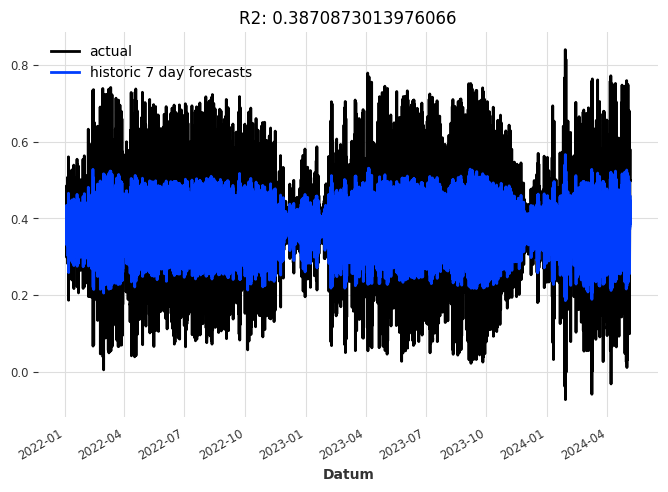

In [213]:
# Evtl. auch was für das FT-Modell?

pred_series = model_nbeats.historical_forecasts(
    darts_ts_full_orig_scaled,
    start=darts_ts_test_orig_scaled.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

display_forecast(
    pred_series,
    darts_ts_full_orig_scaled,
    "7 day",
    start_date=darts_ts_test_orig_scaled.start_time(),
)

# NHITS

In [ ]:
solar_ts_series_nhits = solar_ts_series.reset_index().rename(columns={"Datum":"ds","Leistung":"y"})
solar_ts_series_nhits.insert(column="unique_id", value="UID", loc=2)

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(solar_ts_series_nhits, engine='matplotlib')

In [ ]:
from ray import tune

from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import DistributionLoss, MQLoss

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
horizon = 96 # 24hrs = 4 * 15 min.


# Use your own config or AutoNHITS.default_config
nhits_config = {
    #     "start_padding_enabled": True,
  # oder     "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
        "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       # oder     "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
       "batch_size": tune.choice([7]),                                           # Number of series in windows
#        "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch

       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
    #     "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch

       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
      # oder     "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      #[8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
      #"n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
      #                                [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
      # oder     "n_blocks": 5*[1],                                              # Length of input window
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
    # oder     "mlp_units": 5 * [[64, 64]],                                  # Length of input window
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "random_seed": tune.randint(1, 10),
       "scaler_type": tune.choice(['robust']),
       "val_check_steps": tune.choice([100])
    }

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [ ]:
models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                    config=nhits_config,
                    num_samples=5)]

# oder        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        #AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
nf = NeuralForecast(
    models=models,
    freq="15min"
)

In [ ]:
#nf.fit(df=Y_df)

In [ ]:
#fcst_df = nf.predict()
#fcst_df.columns = fcst_df.columns.str.replace('-median', '')
#fcst_df.head()

In [ ]:
# ... ooder statt fit+predict
if False:
  val_size = 96*10
  test_size = 96*10
  cv_df = nf.cross_validation(solar_ts_series_nhits, n_windows=2)
  %%capture
  Y_hat_df = nf.cross_validation(df=solar_ts_series_nhits, val_size=val_size,
                                test_size=test_size, n_windows=None)

In [ ]:
kwitt
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df = Y_hat_df[(Y_hat_df['unique_id']=='OT') & (Y_hat_df['cutoff']=='2018-02-11 12:00:00')]
Y_hat_df = Y_hat_df.drop(columns=['y','cutoff'])

In [ ]:
plot_df = Y_df.merge(Y_hat_df, on=['unique_id','ds'], how='outer').tail(96*10+50+96*4).head(96*2+96*4)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoNHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'],
                    y1=plot_df['AutoNHITS-lo-90'], y2=plot_df['AutoNHITS-hi-90'],
                    alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df.head()

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        Y_df,
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=48 * 4,
        unique_ids=['H185'],
        engine='matplotlib'
    )

# GP1

In [ ]:
if False:
  # hard-coded but that's fine :)
  from gluonts.dataset.pandas import PandasDataset
  from gluonts.dataset.multivariate_grouper import MultivariateGrouper


  solar_ts_series_gp = solar_ts_series_nhits
  solar_ts_series_gp

  train_ds = PandasDataset.from_long_dataframe(solar_ts_series_gp, target='y', item_id='unique_id', timestamp='ds', freq='15min')
  # I suspect that the grouper is not really necessary and that we could use train_ds directly..
  grouper_train = MultivariateGrouper(max_target_dim=1)
  train_ds = grouper_train(train_ds)

  from gluonts.mx import Trainer, GPVAREstimator

  estimator = GPVAREstimator(freq='15min', prediction_length=h, target_dim=unique_series, context_length=30, trainer = Trainer(ctx='cpu', epochs=5, learning_rate=1e-3))
  predictor = estimator.train(train_ds)

# GP2

In [ ]:
import gpforecaster as gpf
import tsaugmentation as tsag

# Get the data
dataset = 'prison'
data = tsag.preprocessing.PreprocessDatasets(dataset).apply_preprocess()

# Initialize the GPHF model
gpf_model = gpf.model.GPF(dataset, data)

# Train the model
model, like = gpf_model.train()

# Plot the losses
gpf_model.plot_losses()

#GP (Darts)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from darts import TimeSeries
from darts.models import GaussianProcessFilter
from darts.utils import timeseries_generation as tg

In [ ]:
NOISE_DISTANCE = 0.4
SAMPLE_SIZE = 200
np.random.seed(42)

# Prepare the sine wave
x = tg.sine_timeseries(length=SAMPLE_SIZE, value_frequency=0.025)

# Add white noise
noise = tg.gaussian_timeseries(length=SAMPLE_SIZE, std=NOISE_DISTANCE)
x_noise = x + noise

plt.figure(figsize=[12, 8])
x.plot(label="Original sine wave")
x_noise.plot(color="red", label="Noisy sine wave")
plt.legend()
plt.show()



In [ ]:
kernel = ExpSineSquared()
# kernel = RBF()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)

filtered_x_samples = gpf.filter(x_noise, num_samples=100)

plt.figure(figsize=[12, 8])
x.plot(color="black", label="Original sine wave")
x_noise.plot(color="red", label="Noisy sine wave")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered sine wave")
plt.legend()

# Extreme Value Theory

In [ ]:
kwitt

In [ ]:
from pyextremes import __version__, get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
print("pyextremes", __version__)

In [ ]:
# "In order for the analysis results to be meaningful, data needs to be pre-processed by the user.
# This may include removal of data gaps, detrending, interpolation, removal of outliers, etc."
# ==> !! Data needs to be detrended! TODO: Does this also imply constant variance?
# I assume yes and take solar_ts_series_corrected_variance as in input
# TODO: So what exactly does pyextremes expect from the time series?
from pyextremes import EVA

solar_ts_series_corrected_variance

model = EVA(solar_ts_series_corrected_variance)
model

In [ ]:
model.get_extremes(method="BM", block_size="365.2425D")

In [ ]:
model

In [ ]:
model.fit_model()

In [ ]:
model

In [ ]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

In [ ]:
print(summary)

In [ ]:
model.plot_diagnostic(alpha=0.95)

In [ ]:
extremes = get_extremes(
    ts=solar_ts_series_corrected_variance,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

plot_extremes(
    ts=solar_ts_series_corrected_variance,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
)
extremes

In [ ]:
model.get_extremes("POT", threshold=3, r="12H")


In [ ]:
model.plot_extremes(show_clusters=True)

#GP 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split




In [ ]:
# andere Kernel:
#kernel_ =[kernels.RBF (),
         #kernels.RationalQuadratic(),
         #kernels.ExpSineSquared(periodicity=10.0),
         #kernels.DotProduct(sigma_0=1.0)**2,
         #kernels.Matern()
         #]
#print(kernel_, '\n')

# Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [ ]:
train_size = int(len(solar_ts_series_corrected_variance) * 0.7)
ts_train = solar_ts_series_corrected_variance[:train_size]
ts_test = solar_ts_series_corrected_variance[train_size:]

In [ ]:
# oder, für einfache arrays x, y:# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.5, random_state=0)

X_train = ts_train.values.reshape(-1,1)
Y_train = ts_test.values.reshape(-1,1)

In [ ]:
kernel = RBF(length_scale=1)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, Y_train)

# Make predictions on the test data
y_pred, sigma = gp.predict(X_test, return_std=True)

# Visualize the results
x = np.linspace(0, 5, 1000)[:, np.newaxis]
y_mean, y_cov = gp.predict(x, return_cov=True)

plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, c='r', label='Training Data')
plt.plot(x, y_mean, 'k', lw=2, zorder=9, label='Predicted Mean')
plt.fill_between(x[:, 0], y_mean - 1.96 * np.sqrt(np.diag(y_cov)), y_mean + 1.96 *
                 np.sqrt(np.diag(y_cov)), alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
# end of training data: x_t. Before: window, after: horizon
# "predicting a number" = regression problem

In [ ]:
# evtl. nützlich um Modelle zu vergleichen

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# consider using the aggregating version (which loses information though - do we really want that?)
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]


# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Consider using tf.keras.preprocessing.timeseries_dataset_from_array() instead!

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# optional (dense)

import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save bes

# maybe consider using EarlyStopping instead?
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

In [ ]:
# model 2: use different WINDOW_SIZE

In [ ]:
# model 3: horizon > 1 ==> N nodes in the last dense layer, unrolled by make_preds (supposedly)

In [ ]:
# NBEATS
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
ts_train.index

In [ ]:
X_train[0]

In [ ]:
#train_size = int(len(solar_ts_series_corrected_variance) * 0.7)
#ts_train = solar_ts_series_corrected_variance[:train_size]
#ts_test = solar_ts_series_corrected_variance[train_size:]

# Add windowed columns
watts_nbeats = solar_ts_series_corrected_variance.to_frame("Leistung")
for i in range(WINDOW_SIZE):
  watts_nbeats[f"Leistung+{i+1}"] = watts_nbeats["Leistung"].shift(periods=i+1)
watts_nbeats.dropna().head()

X = watts_nbeats.dropna().drop("Leistung", axis=1)
y = watts_nbeats.dropna()["Leistung"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)



#X_train = solar_ts_series_corrected_variance.index.to_numpy()
#X_train = np.array([x.to_pydatetime() for x in X_train]).astype('datetime64[ns]')
#X_test = solar_ts_series_corrected_variance.index.to_numpy()
#X_test = np.array([x.to_pydatetime() for x in X_test]).astype('datetime64[ns]')
#Y_train = ts_train.values.reshape(-1,1)
#Y_test = ts_test.values.reshape(-1,1)



# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(Y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

In [ ]:
watts_nbeats

In [ ]:
X_train

In [ ]:
dt_object = datetime.fromtimestamp(X_train[0])

In [ ]:
X_train

# Naive Model and Backtesting

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Data Preparation for Naive Model
ts = solar_ts_series_corrected_variance
ts = ts.dropna()

In [ ]:
# Moving average model
def moving_average(data: pd.DataFrame, window_size: int=4*3, shift_size: int=96):
    moving_avg = data.rolling(window=window_size).mean()
    shifted_moving_avg = moving_avg.shift(shift_size)
    return(shifted_moving_avg)

In [ ]:
# Plot Naive Model
naive_model = moving_average(ts)

test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Naive Model v.s. Original Data')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
class TimeSeriesPredictionModel():
    """
    Time series prediction model implementation

    Parameters
    ----------
        model_name : class
            Choice of regressor
        model_params : dict
            Definition of model specific tuning parameters

    Functions
    ----------
        train : Train chosen model
        forcast : Apply trained model to prediction period and generate forecast DataFrame
    """
    def __init__(self, model_name,
                 model_params: dict) -> None:
        """Initialize a new instance of time_series_prediction_model."""
        self.model = model_name(**model_params)

    def train(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """Train chosen model."""
        self.X_train = X_train
        self.y_train = y_train
        self.model.fit(self.X_train, self.y_train)

    def forecast(self, X_test: pd.DataFrame) -> pd.DataFrame:
        """Apply trained model to prediction period and generate forecast DataFrame."""
        self.X_test = X_test
        forecast_df = pd.DataFrame(self.model.predict(self.X_test), index=self.X_test.index)
        forecast_df.index.name = 'Datum'
        return forecast_df

In [ ]:
# Dummy data preparation for TimeSeriesPredictionModel

data = pd.DataFrame(index=ts.index, columns=['25h_lag', '24h_lag', 'Original'])
data['Original'] = ts
data['24h_lag'] = ts.shift(96)
data['25h_lag'] = ts.shift(100)

data

In [ ]:
test_date_start = '2024-01-01 00:00+00:00'

In [ ]:
# Dummy Data train-test split
train_df = data[:test_date_start]
train_df = train_df.drop(train_df.tail(1).index)
X_train = train_df[['25h_lag', '24h_lag']]
y_train = train_df[['Original']]

test_df = data[test_date_start:]
X_test = test_df[['25h_lag', '24h_lag']]
y_test = test_df[['Original']]

In [ ]:
# Backtesting mit Sliding Window

def backtesting(X_train: pd.DataFrame, y_train: pd.DataFrame,
                X_test: pd.DataFrame, y_test: pd.DataFrame,
                model: TimeSeriesPredictionModel, prediction_step_size: int=96):

    # initializing output df
    predictions = pd.DataFrame(index=y_test.index, columns=['Original', 'Predictions'])
    predictions['Original'] = y_test

    for i in range(0, len(X_test)-prediction_step_size, prediction_step_size):
        end_idx = i + prediction_step_size
        forecast_index= X_test.iloc[i:end_idx].index

        # fit model and predict
        model.train(X_train, y_train)
        forecast = model.forecast(X_test.iloc[i:end_idx])
        predictions.loc[forecast_index, 'Predictions'] = forecast.to_numpy()

        print(f'Finished Forecast for {forecast_index[-1].date()}')

        # delete old time window from train data
        X_train = X_train.drop(X_train.head(prediction_step_size).index)
        y_train = y_train.drop(y_train.head(prediction_step_size).index)

        # add next time window to train data
        X_train = pd.concat([X_train, X_test.iloc[i:end_idx]])
        y_train = pd.concat([y_train, y_test.iloc[i:end_idx]])

    return predictions

In [ ]:
# Initializing random forest regressor as instance of TimeSeriesPredictionModel
rdnf = TimeSeriesPredictionModel(RandomForestRegressor, {'n_estimators': 10, 'criterion': 'squared_error', 'max_depth': 5})

In [ ]:
rdnf_pred = backtesting(X_train, y_train, X_test, y_test, rdnf)

In [ ]:
rdnf_pred = rdnf_pred.dropna() # ausgehend vom ersten Testzeitraum werden nur vollständige Test-Perioden predicted
rdnf_pred.plot()

In [ ]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def evaluation(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, mape, mse, r2

In [ ]:
mae, mape, mse, r2 = evaluation(rdnf_pred['Original'], rdnf_pred['Predictions'])

print(f'Model: Random Forest \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2}')

In [ ]:
mae, mape, mse, r2 = evaluation(test_ts, naive_model_print)

print(f'Model: Naive Moving Average \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2}')